# Электронно-лучевая сварка

Задача: Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций по совокупности параметров технологических режимов.  
Регрессия.

Целевые переменные:  

- Depth - глубина сварного шва;
- Width - ширина сварного шва.

Используемые признаки:

- IW - величина сварочного тока;

- IF - ток фокусировки электронного пучка;

- VW - скорость сварки;

- FP - расстояние от поверхности образцов до электронно-оптической системы.

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow import keras

# Загрузка данных

In [2]:
df = pd.read_excel('../data/ebw_data.xlsx')

In [3]:
df.shape

(72, 6)

In [4]:
df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


# Первичный анализ данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IW,72.0,45.666667,1.678363,43.00,44.00,45.50,47.00,49.00
IF,72.0,141.333333,5.145763,131.00,139.00,141.00,146.00,150.00
VW,72.0,8.638889,2.061078,4.50,8.00,9.00,10.00,12.00
FP,72.0,78.333333,21.493530,50.00,60.00,80.00,80.00,125.00
Depth,72.0,1.195556,0.225081,0.80,1.08,1.20,1.29,1.76
Width,72.0,1.970417,0.279040,1.68,1.76,1.84,2.05,2.60


In [7]:
df.nunique()

IW        7
IF        8
VW        5
FP        5
Depth    29
Width    25
dtype: int64

In [8]:
df.duplicated().sum()

7

In [9]:
df.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

#### Отсутствуют пропущенные поля, однако есть задублированные строки.


## Удаление задублированных строк

In [10]:
df = df.drop_duplicates()

In [11]:
df.duplicated().sum()

0

## Визуальный анализ данных

In [12]:
from matplotlib.colorbar import colorbar_factory
def histodraw(df, variables, n_rows, n_cols):
  fig=plt.figure(figsize=(15, 10))
  for i, var_name in enumerate(variables):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    sns.histplot(data=df, x=var_name, kde=True, bins=30, color = 'blue')
  fig.tight_layout()
  plt.show()

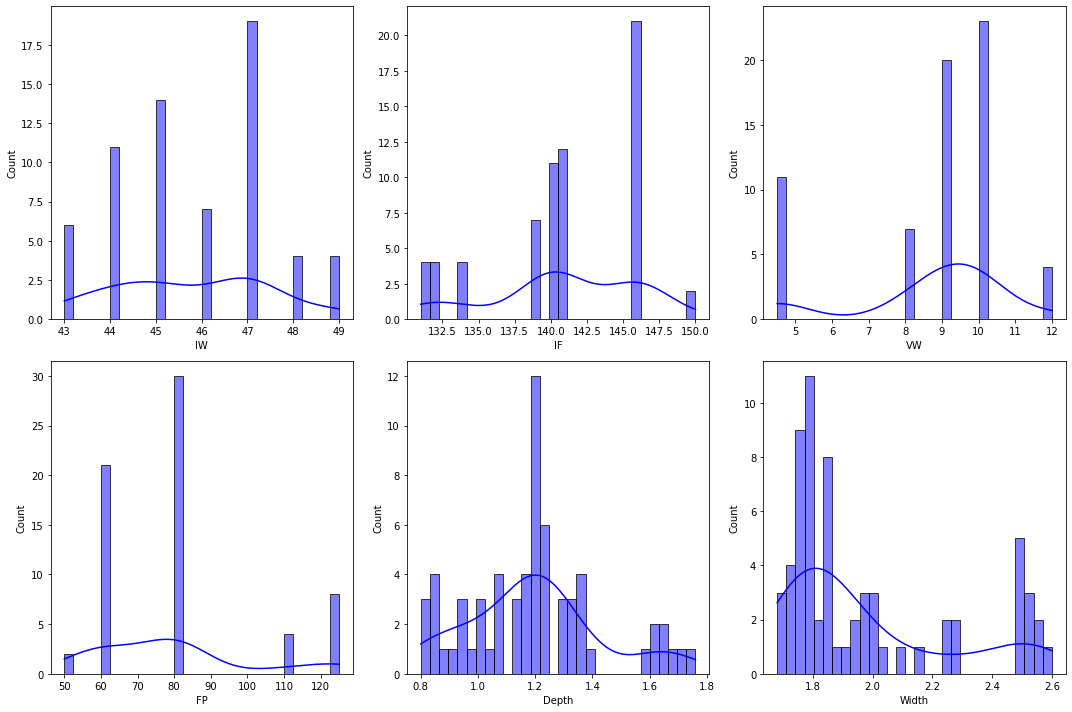

In [13]:
histodraw(df, df.columns, 2, 3)

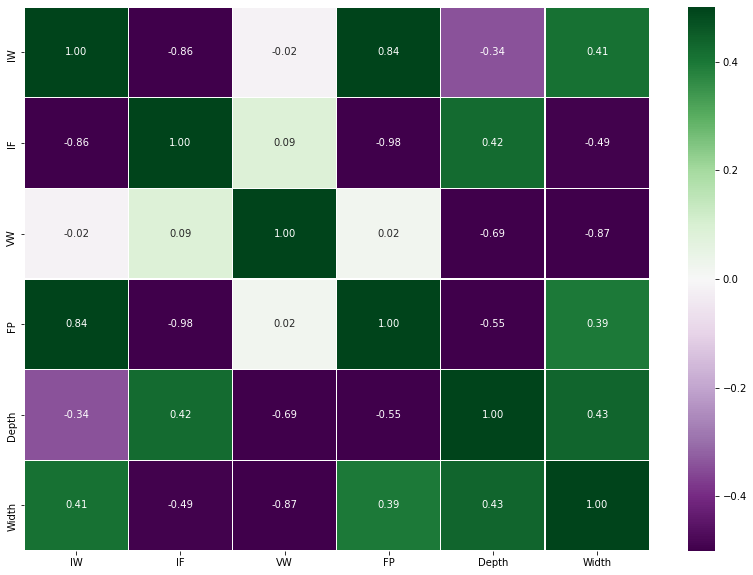

In [14]:
cor_map = df.corr()
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(cor_map, vmin=-0.5, vmax=0.5, annot=True, fmt='.2f',cmap='PRGn', ax=ax, linewidths = 0.1)
plt.show()

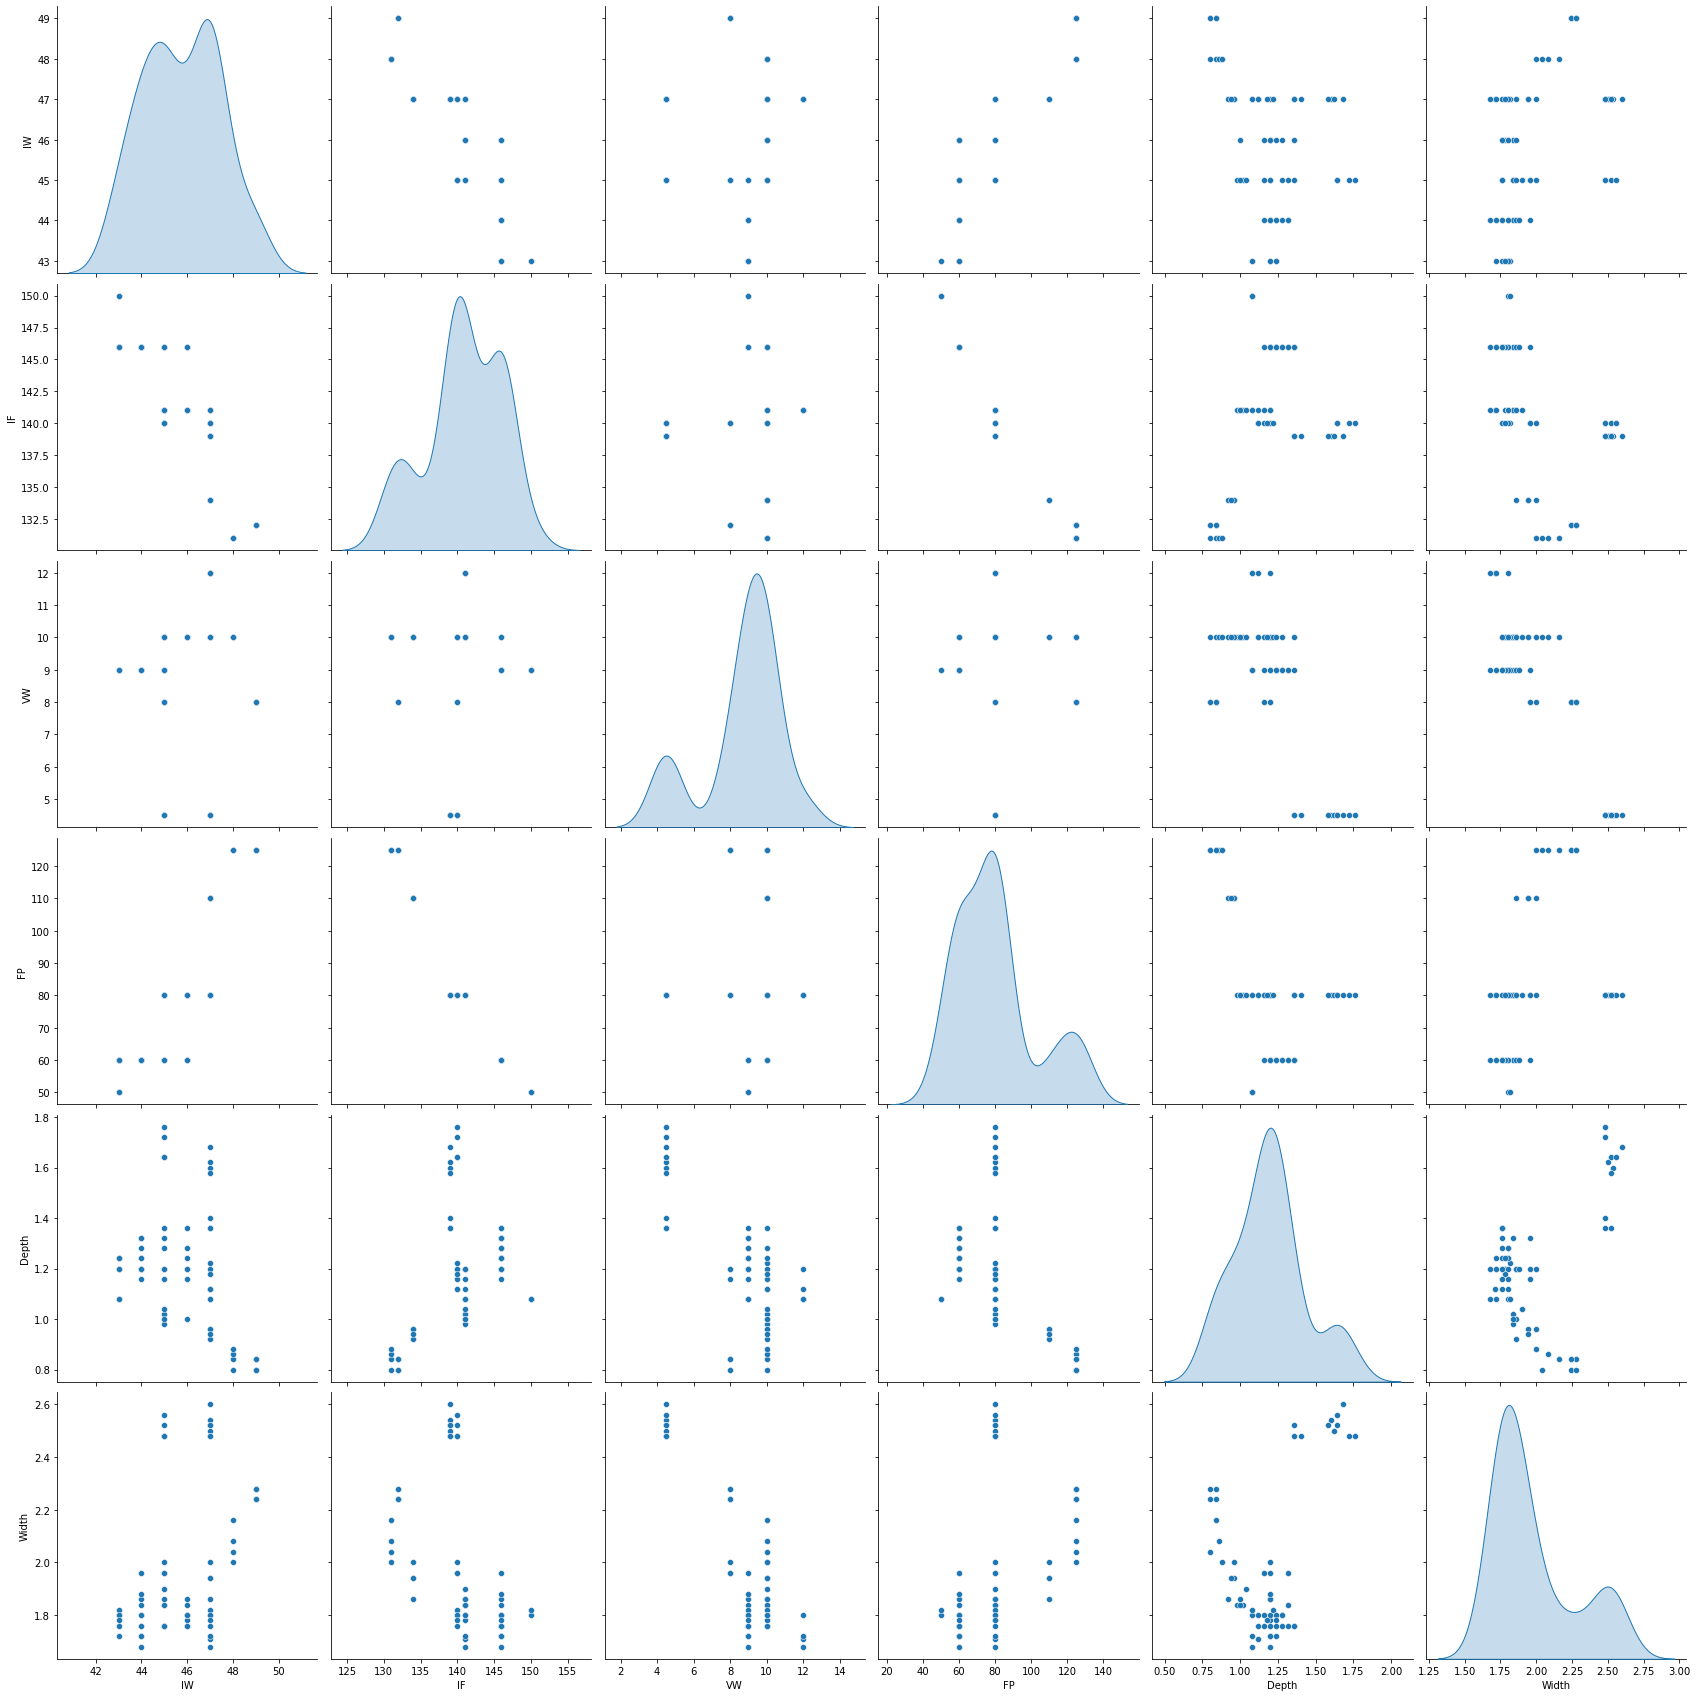

In [15]:
sns.pairplot(df, height=4, diag_kind='kde');

#### Наибольшую корреляцию с целевыми признаками "Width" и "Depth" имеет признак "VW"!

# Анализ выбросов

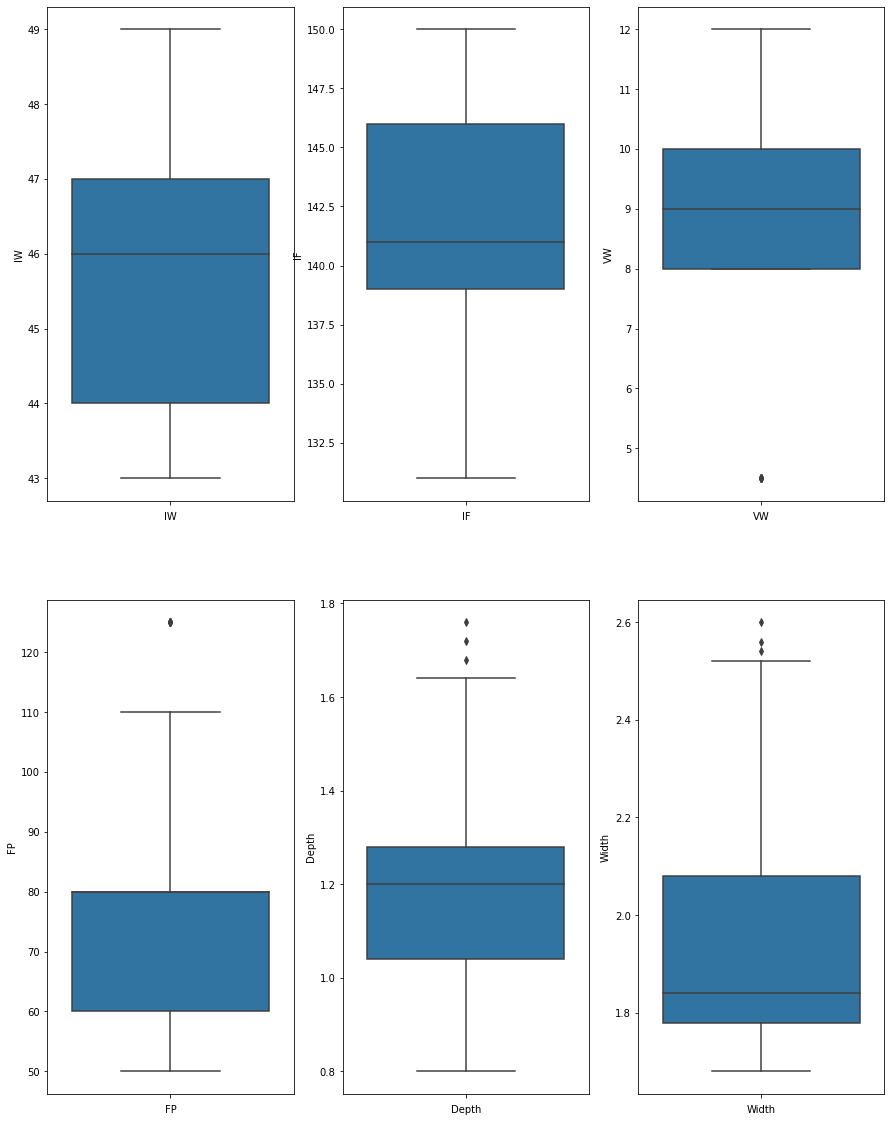

In [16]:
n = 1 # счетчик
s = 2 # строки
c = 3 # столбцы
fig = plt.figure(figsize=(15, 20))
for i in df.columns:
  plt.subplot(s, c, n)
  plt.xlabel(i)
  sns.boxplot(y = df[i])
  n = n + 1
plt.show()

In [17]:
sgm = 0
iqd= 0
for column in df:
  d = df.loc[:, [column]]
  # методом 3-х сигм
  zscore = (df[column] - df[column].mean()) / df[column].std()
  d['3s'] = zscore.abs() > 3
  sgm += d['3s'].sum()
  # методом межквартильных расстояний
  q1 = np.quantile(df[column], 0.25)
  q3 = np.quantile(df[column], 0.75)
  iqr = q3 - q1
  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr
  d['iq'] = (df[column] <= lower) | (df[column] >= upper)
  iqd+= d['iq'].sum()
print( sgm,'- выбросов найдено методом 3-х сигм',)
print( iqd,'- выбросов найдено методом межквартильных расстояний',)

0 - выбросов найдено методом 3-х сигм
29 - выбросов найдено методом межквартильных расстояний


In [18]:
df3 = df.copy()
for i in df.columns:
  df3[i] = abs((df[i] -  df[i].mean()) / df[i].std())
  print(f"{sum(df3[i] > 3)} -> выбросов в признаке: '{i}'")
print(f' Всего - {sum(sum(df3.values > 3))} выброса')

0 -> выбросов в признаке: 'IW'
0 -> выбросов в признаке: 'IF'
0 -> выбросов в признаке: 'VW'
0 -> выбросов в признаке: 'FP'
0 -> выбросов в признаке: 'Depth'
0 -> выбросов в признаке: 'Width'
 Всего - 0 выброса


In [19]:
cnt = 0
for column in df:
  d = df.loc[:, [column]]
  q1 = np.quantile(df[column], 0.25)
  q3 = np.quantile(df[column], 0.75)
  iqr = q3 - q1
  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr
  num = sum((df[column] <= lower) | (df[column] >= upper))
  print(f"{num} -> выбросов в признаке: '{column}'")
  cnt = cnt + num
print(f' Всего - {cnt} выброса')


0 -> выбросов в признаке: 'IW'
0 -> выбросов в признаке: 'IF'
11 -> выбросов в признаке: 'VW'
12 -> выбросов в признаке: 'FP'
3 -> выбросов в признаке: 'Depth'
3 -> выбросов в признаке: 'Width'
 Всего - 29 выброса


#### Количество данных не позволяет проводить удаление выбросов методом межквартильных расстояний

## Оценка плотности ядра

<AxesSubplot:ylabel='Density'>

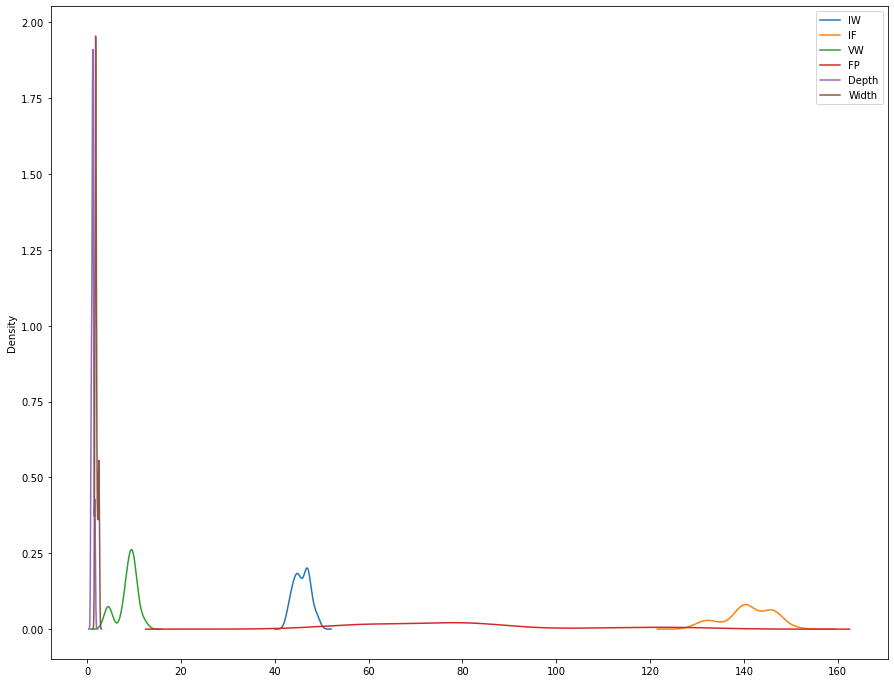

In [20]:
fig, ax = plt.subplots(figsize=(15, 12))
df.plot(kind='kde', ax=ax)

## Нормализация данных

In [21]:
scaler = MinMaxScaler()
names = df.columns
d = scaler.fit_transform(df)
df_norm = pd.DataFrame(d, columns=names).round(2)
df_norm.head()

,IW,IF,VW,FP,Depth,Width
0,0.67,0.42,0.0,0.4,0.83,0.93
1,0.67,0.42,0.0,0.4,0.85,0.89
2,0.67,0.42,0.0,0.4,0.92,1.00
3,0.67,0.42,0.0,0.4,0.81,0.91
4,0.33,0.47,0.0,0.4,1.00,0.87


<AxesSubplot:ylabel='Density'>

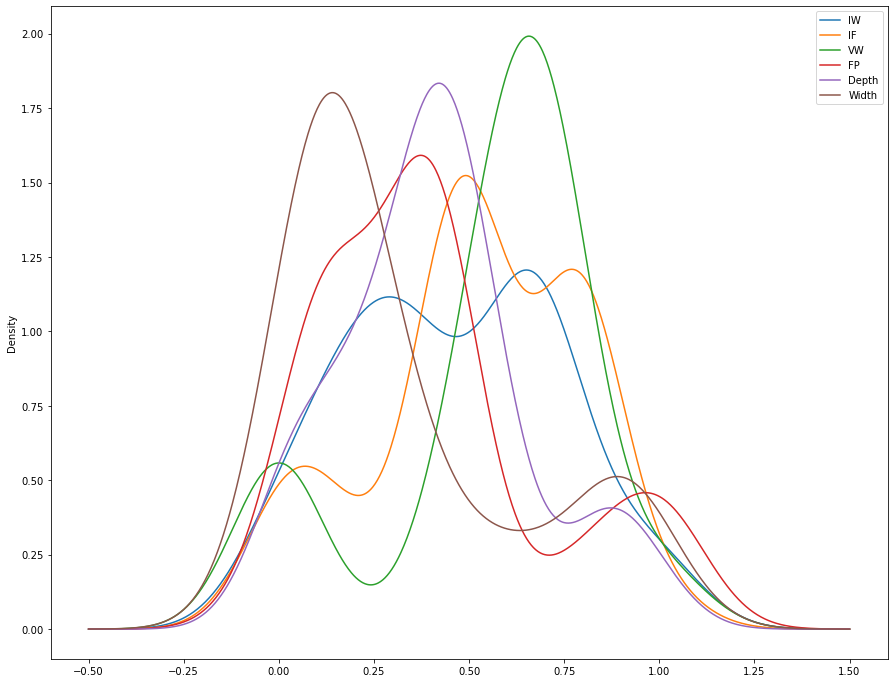

In [22]:
fig, ax = plt.subplots(figsize=(15, 12))
df_norm.plot(kind='kde', ax=ax)

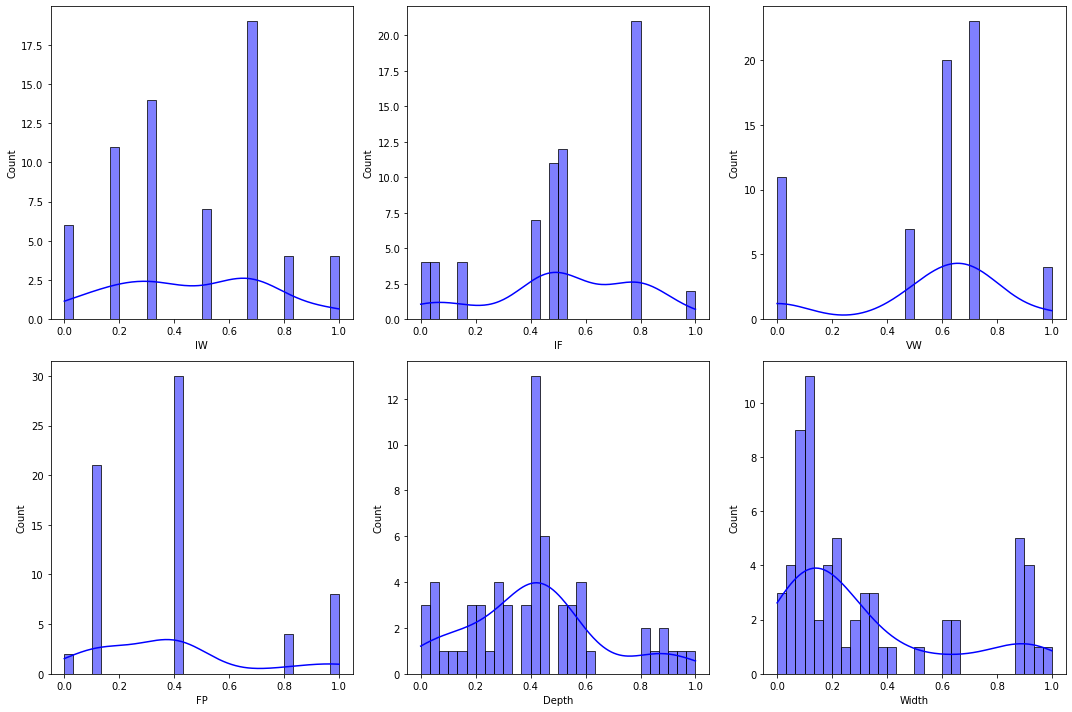

In [23]:
histodraw(df_norm, df.columns, 2, 3)

# Подготовка данных для моделей

In [24]:
X = df_norm.drop(columns=["Depth", "Width"])
y = df_norm.loc[:,['Depth', 'Width']]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Исследование моделей

#### Будем строить отдельные модели для каждой целевой переменной и заносить метрики для каждой модели в сводную таблицу

In [26]:
# Сводная таблица по результатам исследований для различных моделей
errors_df = pd.DataFrame(columns=['target_var','model_name','MSE','MAE','R2'])

In [27]:
# Функция для визуального анализа предсказаний.
# Отрисовывает зависимость предсказанных значений от истинных, а также ось 45 гр., на которой должны лежать идеальные предсказания.
def predicted_plot(orig, predict, model_name):
  plt.figure(figsize=(6,6))
  plt.title(f' Качество предсказаний: \n модели {model_name}')
  plt.scatter(orig, predict)
  plt.xlabel('Истинные значения: ' + orig.name)
  plt.ylabel('Предсказания: ' + orig.name)
  lims = [min(orig.min(),predict.min()) , max(orig.max(),predict.max())]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)

## Линейная регрессия

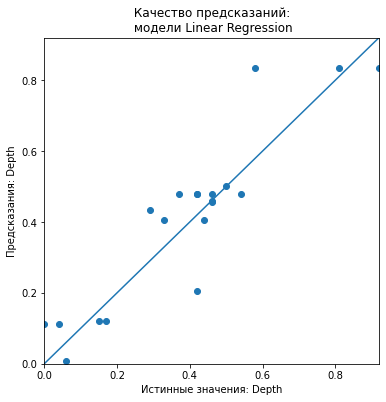

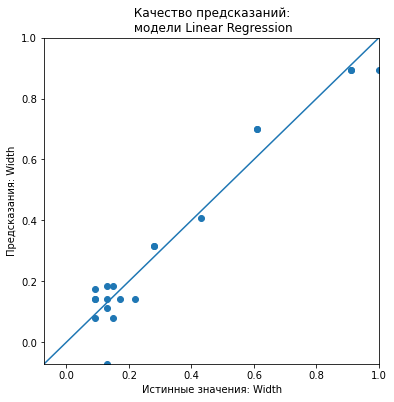

In [28]:
model_num = 0
model_name = 'Linear Regression'
MSE_LR   = []
MAE_LR   = []
R2_LR    = []
for k in range (0, y_train.columns.size):
    model_LR = LinearRegression()
    model_LR.fit(X_train, y_train.iloc[:, k])
    pred_LR = model_LR.predict(X_test)
    MSE_LR.append(metrics.mean_squared_error(y_test.iloc[:, k], pred_LR))
    MAE_LR.append(metrics.mean_absolute_error(y_test.iloc[:, k], pred_LR))
    R2_LR.append(metrics.r2_score(y_test.iloc[:, k], pred_LR))
    predicted_plot(y_test.iloc[:, k], pred_LR, model_name)
    errors_df.loc[model_num*y_train.columns.size+k,:] = [y_test.iloc[:, k].name, model_name, MSE_LR[k], MAE_LR[k], R2_LR[k]]


## Случайный лес

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


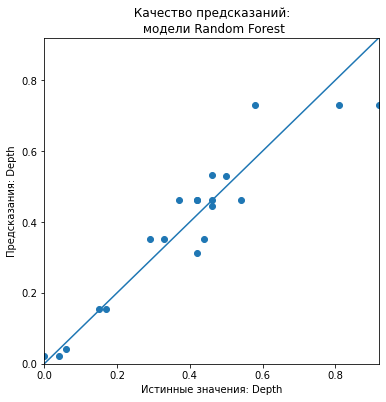

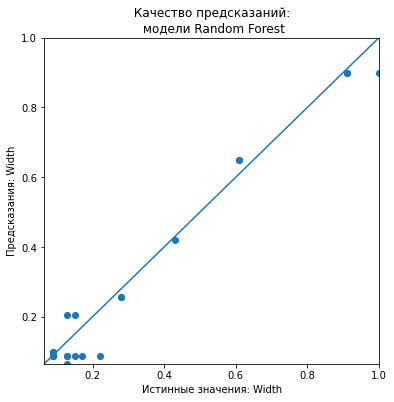

In [29]:
model_num = 1
model_name = 'Random Forest'
MSE_RF   = []
MAE_RF   = []
R2_RF    = []
Best_RF  = []
for k in range (0, y_train.columns.size):
    model_RF = RandomForestRegressor(random_state=1)
    param_grid_RF = {
       'n_estimators': [10, 20, 50, 100, 150, 200],
       'max_features': ['auto', 'sqrt', 'log2'],
       'max_depth' : [1,2,3,4,5],
       'criterion' :['mse', 'mae']
    }
    GSCV_RF = GridSearchCV(estimator=model_RF, param_grid=param_grid_RF, cv=5, verbose=1)
    GSCV_RF.fit(X_train, y_train.iloc[:, k])
    Best_RF.append(GSCV_RF.best_params_)
    pred_RF = GSCV_RF.best_estimator_.predict(X_test)
    MSE_RF.append(metrics.mean_squared_error(y_test.iloc[:, k], pred_RF))
    MAE_RF.append(metrics.mean_absolute_error(y_test.iloc[:, k], pred_RF))
    R2_RF.append(metrics.r2_score(y_test.iloc[:, k], pred_RF))
    predicted_plot(y_test.iloc[:, k], pred_RF, model_name)
    errors_df.loc[model_num*y_train.columns.size+k,:] = [y_test.iloc[:, k].name, model_name, MSE_RF[k], MAE_RF[k], R2_RF[k]]

In [30]:
Best_RF

[{'criterion': 'mse',
  'max_depth': 5,
  'max_features': 'sqrt',
  'n_estimators': 50},
 {'criterion': 'mae',
  'max_depth': 4,
  'max_features': 'auto',
  'n_estimators': 10}]

## k - ближайших соседей

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


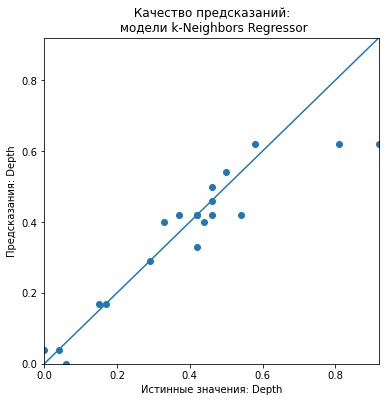

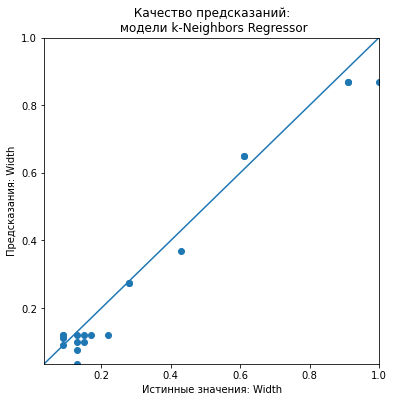

In [31]:
model_num = 2
model_name = 'k-Neighbors Regressor'
MSE_KN   = []
MAE_KN   = []
R2_KN    = []
Best_KN  = []
for k in range (0, y_train.columns.size):
    model_KN = KNeighborsRegressor()
    param_grid_KN = {
       'n_neighbors': [1, 2, 5, 10, 20, 30]
    }
    GSCV_KN = GridSearchCV(estimator=model_KN, param_grid=param_grid_KN, cv=5, verbose=1)
    GSCV_KN.fit(X_train, y_train.iloc[:, k])
    Best_KN.append(GSCV_KN.best_params_)
    pred_KN = GSCV_KN.best_estimator_.predict(X_test)
    MSE_KN.append(metrics.mean_squared_error(y_test.iloc[:, k], pred_KN))
    MAE_KN.append(metrics.mean_absolute_error(y_test.iloc[:, k], pred_KN))
    R2_KN.append(metrics.r2_score(y_test.iloc[:, k], pred_KN))
    predicted_plot(y_test.iloc[:, k], pred_KN, model_name)
    errors_df.loc[model_num*y_train.columns.size+k,:] = [y_test.iloc[:, k].name, model_name, MSE_KN[k], MAE_KN[k], R2_KN[k]]

In [32]:
Best_KN

[{'n_neighbors': 1}, {'n_neighbors': 2}]

## Многослойный перцептрон

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multi

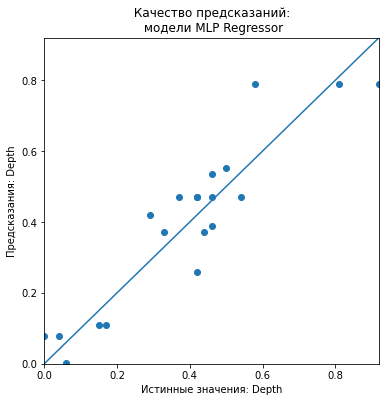

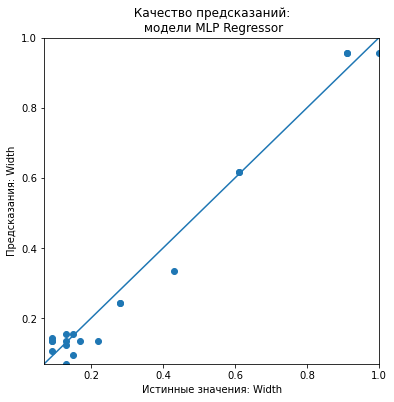

In [33]:
model_num = 3
model_name = 'MLP Regressor'
MSE_MLP   = []
MAE_MLP   = []
R2_MLP    = []
Best_MLP  = []
for k in range (0, y_train.columns.size):
    model_MLP = MLPRegressor(random_state=1)
    param_grid_MLP = {
        'hidden_layer_sizes' : [(32, 16, 8), (16, 20, 8, 4), (20, 18, 16, 14, 12), (100, 100, 50, 25, 12), (144, 144, 144, 72, 72, 36, 36)],
        'activation' : ['identity', 'logistic', 'tanh', 'relu'],
        'solver' : ['sgd', 'adam'],
        'max_iter' : [200],
        'learning_rate' : ['constant', 'adaptive', 'invscaling']
    }
    GSCV_MLP = GridSearchCV(estimator=model_MLP, param_grid=param_grid_MLP, cv=5, verbose=0)
    GSCV_MLP.fit(X_train, y_train.iloc[:, k])
    Best_MLP.append(GSCV_MLP.best_params_)
    pred_MLP = GSCV_MLP.best_estimator_.predict(X_test)
    MSE_MLP.append(metrics.mean_squared_error(y_test.iloc[:, k], pred_MLP))
    MAE_MLP.append(metrics.mean_absolute_error(y_test.iloc[:, k], pred_MLP))
    R2_MLP.append(metrics.r2_score(y_test.iloc[:, k], pred_MLP))
    predicted_plot(y_test.iloc[:, k], pred_MLP, model_name)
    errors_df.loc[model_num*y_train.columns.size+k,:] = [y_test.iloc[:, k].name, model_name, MSE_MLP[k], MAE_MLP[k], R2_MLP[k]]

In [34]:
Best_MLP

[{'activation': 'relu',
  'hidden_layer_sizes': (144, 144, 144, 72, 72, 36, 36),
  'learning_rate': 'constant',
  'max_iter': 200,
  'solver': 'adam'},
 {'activation': 'relu',
  'hidden_layer_sizes': (100, 100, 50, 25, 12),
  'learning_rate': 'constant',
  'max_iter': 200,
  'solver': 'adam'}]

# Результаты исследования моделей

In [35]:
errors_df

,target_var,model_name,MSE,MAE,R2
0,Depth,Linear Regression,0.009699,0.073316,0.815485
1,Width,Linear Regression,0.005044,0.055646,0.943529
2,Depth,Random Forest,0.005734,0.057666,0.890914
3,Width,Random Forest,0.003043,0.04255,0.965935
4,Depth,k-Neighbors Regressor,0.00848,0.057,0.838679
5,Width,k-Neighbors Regressor,0.002905,0.043,0.967476
6,Depth,MLP Regressor,0.00802,0.075754,0.847425
7,Width,MLP Regressor,0.002061,0.037647,0.976929


#### Наилучшие результаты при анализе для целевого параметра 'Width' показал многослойный перцептрон, а для целевого параметра 'Depth' - модель на основе случайного леса. Выберем в качестве основной модели многослойный перцептрон и подберём параметры для обоих целевых параметров с помощью Keras.

# Рабочая модель

In [36]:
# для многослойного перцептрона будем использовать не нормализованные данные
X = df.drop(columns=["Depth", "Width"])
y = df.loc[:,['Depth', 'Width']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [37]:
# добавим слой нормализации в перцетрон
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X))
print(normalizer.mean.numpy())

[[ 45.76923 140.9077    8.66923  80.     ]]


In [38]:
# Функция для визуализации процесса обучения
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 1])
    plt.xlabel('Эпоха')
    plt.ylabel('LOSS')
    plt.legend()
    plt.grid(True)

In [39]:
# Функция для создания модели 
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      keras.layers.Dense(100, input_dim=4, activation='relu'),
      keras.layers.Dense(100, activation='relu'),  
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(25, activation='relu'),
      keras.layers.Dense(12, activation='relu'),
      keras.layers.Dense(2)
    ])

    model.compile(loss='mean_squared_error', #loss='mean_absolute_error',loss='mean_squared_error'
                optimizer=keras.optimizers.Adam(0.002), metrics=['mae','mse'])
    return model

In [40]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 12)                312       
                                                        

In [41]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=2, epochs=250)

Epoch 1/250
2/2 - 2s - loss: 2.6605 - mae: 1.5691 - mse: 2.6605 - val_loss: 2.7883 - val_mae: 1.6147 - val_mse: 2.7883 - 2s/epoch - 1s/step
Epoch 2/250
2/2 - 0s - loss: 2.5298 - mae: 1.5407 - mse: 2.5298 - val_loss: 2.6523 - val_mae: 1.5848 - val_mse: 2.6523 - 41ms/epoch - 21ms/step
Epoch 3/250
2/2 - 0s - loss: 2.3651 - mae: 1.5001 - mse: 2.3651 - val_loss: 2.4918 - val_mae: 1.5454 - val_mse: 2.4918 - 42ms/epoch - 21ms/step
Epoch 4/250
2/2 - 0s - loss: 2.1795 - mae: 1.4490 - mse: 2.1795 - val_loss: 2.2976 - val_mae: 1.4899 - val_mse: 2.2976 - 42ms/epoch - 21ms/step
Epoch 5/250
2/2 - 0s - loss: 1.9592 - mae: 1.3780 - mse: 1.9592 - val_loss: 2.0718 - val_mae: 1.4127 - val_mse: 2.0718 - 41ms/epoch - 21ms/step
Epoch 6/250
2/2 - 0s - loss: 1.7118 - mae: 1.2805 - mse: 1.7118 - val_loss: 1.8262 - val_mae: 1.3119 - val_mse: 1.8262 - 44ms/epoch - 22ms/step
Epoch 7/250
2/2 - 0s - loss: 1.4466 - mae: 1.1514 - mse: 1.4466 - val_loss: 1.5601 - val_mae: 1.1822 - val_mse: 1.5601 - 41ms/epoch - 21ms/s

Epoch 58/250
2/2 - 0s - loss: 0.0402 - mae: 0.1580 - mse: 0.0402 - val_loss: 0.0908 - val_mae: 0.2506 - val_mse: 0.0908 - 49ms/epoch - 25ms/step
Epoch 59/250
2/2 - 0s - loss: 0.0442 - mae: 0.1709 - mse: 0.0442 - val_loss: 0.0876 - val_mae: 0.2472 - val_mse: 0.0876 - 45ms/epoch - 23ms/step
Epoch 60/250
2/2 - 0s - loss: 0.0424 - mae: 0.1667 - mse: 0.0424 - val_loss: 0.0718 - val_mae: 0.2209 - val_mse: 0.0718 - 49ms/epoch - 25ms/step
Epoch 61/250
2/2 - 0s - loss: 0.0369 - mae: 0.1520 - mse: 0.0369 - val_loss: 0.0567 - val_mae: 0.1905 - val_mse: 0.0567 - 43ms/epoch - 22ms/step
Epoch 62/250
2/2 - 0s - loss: 0.0347 - mae: 0.1444 - mse: 0.0347 - val_loss: 0.0497 - val_mae: 0.1842 - val_mse: 0.0497 - 46ms/epoch - 23ms/step
Epoch 63/250
2/2 - 0s - loss: 0.0327 - mae: 0.1421 - mse: 0.0327 - val_loss: 0.0494 - val_mae: 0.1856 - val_mse: 0.0494 - 44ms/epoch - 22ms/step
Epoch 64/250
2/2 - 0s - loss: 0.0299 - mae: 0.1390 - mse: 0.0299 - val_loss: 0.0540 - val_mae: 0.1911 - val_mse: 0.0540 - 47ms/epo

Epoch 115/250
2/2 - 0s - loss: 0.0057 - mae: 0.0566 - mse: 0.0057 - val_loss: 0.0082 - val_mae: 0.0757 - val_mse: 0.0082 - 43ms/epoch - 22ms/step
Epoch 116/250
2/2 - 0s - loss: 0.0068 - mae: 0.0646 - mse: 0.0068 - val_loss: 0.0080 - val_mae: 0.0733 - val_mse: 0.0080 - 42ms/epoch - 21ms/step
Epoch 117/250
2/2 - 0s - loss: 0.0065 - mae: 0.0623 - mse: 0.0065 - val_loss: 0.0072 - val_mae: 0.0712 - val_mse: 0.0072 - 47ms/epoch - 24ms/step
Epoch 118/250
2/2 - 0s - loss: 0.0052 - mae: 0.0538 - mse: 0.0052 - val_loss: 0.0078 - val_mae: 0.0725 - val_mse: 0.0078 - 41ms/epoch - 21ms/step
Epoch 119/250
2/2 - 0s - loss: 0.0054 - mae: 0.0580 - mse: 0.0054 - val_loss: 0.0101 - val_mae: 0.0813 - val_mse: 0.0101 - 43ms/epoch - 22ms/step
Epoch 120/250
2/2 - 0s - loss: 0.0080 - mae: 0.0740 - mse: 0.0080 - val_loss: 0.0101 - val_mae: 0.0819 - val_mse: 0.0101 - 44ms/epoch - 22ms/step
Epoch 121/250
2/2 - 0s - loss: 0.0079 - mae: 0.0726 - mse: 0.0079 - val_loss: 0.0078 - val_mae: 0.0725 - val_mse: 0.0078 - 5

Epoch 172/250
2/2 - 0s - loss: 0.0045 - mae: 0.0516 - mse: 0.0045 - val_loss: 0.0054 - val_mae: 0.0583 - val_mse: 0.0054 - 42ms/epoch - 21ms/step
Epoch 173/250
2/2 - 0s - loss: 0.0044 - mae: 0.0500 - mse: 0.0044 - val_loss: 0.0053 - val_mae: 0.0570 - val_mse: 0.0053 - 40ms/epoch - 20ms/step
Epoch 174/250
2/2 - 0s - loss: 0.0042 - mae: 0.0491 - mse: 0.0042 - val_loss: 0.0056 - val_mae: 0.0576 - val_mse: 0.0056 - 40ms/epoch - 20ms/step
Epoch 175/250
2/2 - 0s - loss: 0.0045 - mae: 0.0515 - mse: 0.0045 - val_loss: 0.0056 - val_mae: 0.0569 - val_mse: 0.0056 - 40ms/epoch - 20ms/step
Epoch 176/250
2/2 - 0s - loss: 0.0045 - mae: 0.0510 - mse: 0.0045 - val_loss: 0.0053 - val_mae: 0.0562 - val_mse: 0.0053 - 40ms/epoch - 20ms/step
Epoch 177/250
2/2 - 0s - loss: 0.0042 - mae: 0.0492 - mse: 0.0042 - val_loss: 0.0051 - val_mae: 0.0557 - val_mse: 0.0051 - 41ms/epoch - 21ms/step
Epoch 178/250
2/2 - 0s - loss: 0.0042 - mae: 0.0486 - mse: 0.0042 - val_loss: 0.0051 - val_mae: 0.0556 - val_mse: 0.0051 - 4

Epoch 229/250
2/2 - 0s - loss: 0.0038 - mae: 0.0458 - mse: 0.0038 - val_loss: 0.0041 - val_mae: 0.0514 - val_mse: 0.0041 - 42ms/epoch - 21ms/step
Epoch 230/250
2/2 - 0s - loss: 0.0038 - mae: 0.0462 - mse: 0.0038 - val_loss: 0.0038 - val_mae: 0.0500 - val_mse: 0.0038 - 41ms/epoch - 21ms/step
Epoch 231/250
2/2 - 0s - loss: 0.0034 - mae: 0.0425 - mse: 0.0034 - val_loss: 0.0042 - val_mae: 0.0555 - val_mse: 0.0042 - 41ms/epoch - 21ms/step
Epoch 232/250
2/2 - 0s - loss: 0.0035 - mae: 0.0456 - mse: 0.0035 - val_loss: 0.0046 - val_mae: 0.0581 - val_mse: 0.0046 - 41ms/epoch - 21ms/step
Epoch 233/250
2/2 - 0s - loss: 0.0041 - mae: 0.0486 - mse: 0.0041 - val_loss: 0.0042 - val_mae: 0.0548 - val_mse: 0.0042 - 41ms/epoch - 21ms/step
Epoch 234/250
2/2 - 0s - loss: 0.0039 - mae: 0.0468 - mse: 0.0039 - val_loss: 0.0034 - val_mae: 0.0475 - val_mse: 0.0034 - 41ms/epoch - 21ms/step
Epoch 235/250
2/2 - 0s - loss: 0.0038 - mae: 0.0466 - mse: 0.0038 - val_loss: 0.0032 - val_mae: 0.0447 - val_mse: 0.0032 - 4

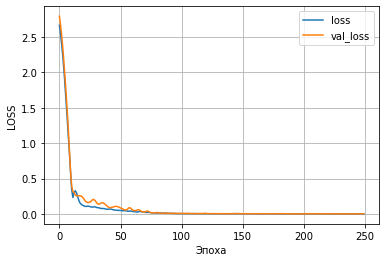

In [42]:
plot_loss(history)

In [43]:
prediction = dnn_model.predict(X_test)
errors_ddn = pd.DataFrame(columns=['target_var','MSE','MAE','R2'])
errors_ddn.loc[0,:] = [y_test.iloc[:, 0].name, metrics.mean_squared_error(y_test.iloc[:,0], prediction[:,0]), metrics.mean_absolute_error(y_test.iloc[:,0], prediction[:,0]), metrics.r2_score(y_test.iloc[:,0], prediction[:,0])]
errors_ddn.loc[1,:] = [y_test.iloc[:, 1].name, metrics.mean_squared_error(y_test.iloc[:,1], prediction[:,1]), metrics.mean_absolute_error(y_test.iloc[:,1], prediction[:,1]), metrics.r2_score(y_test.iloc[:,1], prediction[:,1])]
errors_ddn

1/1 [==============================] - 0s 145ms/step


,target_var,MSE,MAE,R2
0,Depth,0.00679,0.063509,0.859667
1,Width,0.002303,0.038635,0.969686


### Сохранение модели

In [44]:
model_path = "../model"

In [45]:
dnn_model.save(model_path)

INFO:tensorflow:Assets written to: ../model\assets


INFO:tensorflow:Assets written to: ../model\assets


### Проверка сохранённой модели

In [46]:
reconstructed_model = keras.models.load_model(model_path)

In [47]:
reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 12)                312       
                                                        

In [48]:
reconstructed_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 214ms/step - loss: 0.0045 - mae: 0.0511 - mse: 0.0045


[0.004546632524579763, 0.05107180029153824, 0.004546632524579763]

#### Модель готова к встраиванию в приложение